# Implémentation d'un réseau convolutif

Dans ce second TD, on va partir de ce qui a été fait dans le premier TD pour implémenter un réseau convolutif. L'objectif de ce TD sera d'implémenter manuellement un [LeNet5](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) et de l'entrainer sur MNIST. 

Sources:
* https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a 
* https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320
* http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
* https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/


In [3]:
# librairies
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
# import mnist # package à installer conda install -c conda-forge mnist
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

/Users/gabriel/miniconda3/envs/PV4GER/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Données

Jusqu'à présent, on a travaillé sur une version "simplifiée" de MNIST. Les données d'entrée n'avaient qu'une dimension de 64. Dans la suite, on va récupérer les "vraies" données de MNIST, i.e. des vignettes $28\times28$. La dimensionnalité de l'espace d'entrée est désormais de 784. On peut récupérer les données directement avec la librairie `torchvision` de Pytorch.

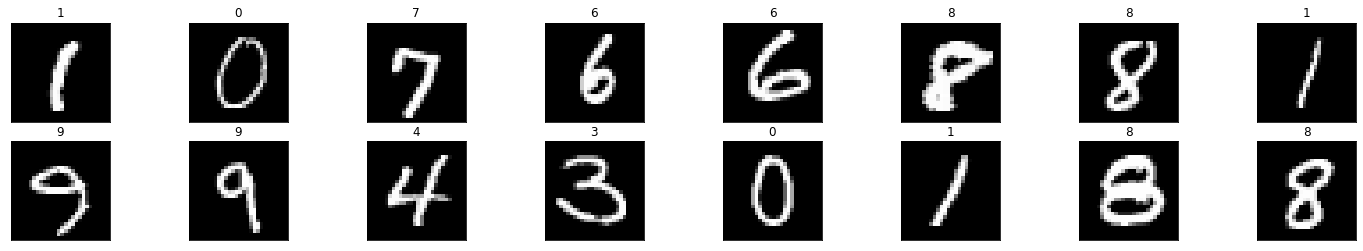

In [5]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 256

# percentage of training set to use as validation
valid_size = 0.2# convert data to torch.FloatTensor

transform = transforms.ToTensor()# choose the training and testing datasets

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)# obtain training indices that will be used for validation
num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)


# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()# plot the images in the batch, along with the corresponding labels


fig = plt.figure(figsize=(25, 4))

batch_display = 16

for idx in np.arange(batch_display):
    ax = fig.add_subplot(2, int(batch_display/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Définition d'un réseau avec Pytorch

Dans la fin du TD précédent, on a vu que l'implémentation d'un réseau de neurones pouvait rapidement être fastidieuse. Pour standardiser et faciliter le développement de réseaux de neurones, il existe un certain nombre de librairies. Les plus populaires actuellement sont Tensorflow et Pytorch. Ces librairies permettent non seulement de faciliter et d'optimiser l'implémentation de réseaux de neurones, mais prennent aussi en charge la parallélisation sur GPU de manière assez simple.

### Réseau multi-couche

On va réimplémenter, mais avec Pytorch, un réseau de neurones multicouche. On modifie la fonction d'activation pour passer au relu. Cette fonction d'activation présente l'avantage d'éviter les phénomènes de [disparition de gradient](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484) lors de l'entrainement.

Dans l'exemple ci-dessous, on définit un attribut `layers` qui rassemble toutes les couches du modèle. L'utilisateur spécifie seulement la taille des couches cachées. Au sein de l'attribut `layers`, on utilise le module `Sequential` qui permet de "cascader" les différentes transformations qu'on applique aux inputs. L'attribut `nn.Linear` correspond à une couche complètement connectée. La non linéarité est ensuite appliquée en appelant la fonction `nn.ReLU`.

#### Architecture


In [6]:
# define NN architecture

class MLP(nn.Module):
    def __init__(self, hidden_1, hidden_2):
        super(MLP,self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features = 28*28, out_features = hidden_1, bias=True), # on explicite les arguments que prend la fonction nn.Linear
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, 10)
        )
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        return self.layers(x)
        
# initialize the model, the loss function and the optimizer
model = MLP(120,84)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


#### Entrainement

Dans la cellule ci-dessous, on met en place la boucle d'entrainement. On peut remarquer les similarités avec ce qui a été fait précédemment. Attention, en fonction des paramètres spécifiés et des caractéristiques de votre machine, cette cellule peut prendre du temps à être exécutée.

tensor([[ 0.3178, -1.4970, -0.3667,  ...,  0.4455,  0.0192,  0.7751],
        [-0.0224, -0.5885,  0.7668,  ..., -1.7685,  0.5560, -0.7795],
        [ 0.1037, -1.3851, -1.2442,  ...,  2.3992, -0.2713,  1.8440],
        ...,
        [-0.7913,  0.6995,  0.8081,  ..., -0.7709,  0.7934, -0.6165],
        [-1.2883,  0.4737,  0.4539,  ..., -0.7364,  0.5413, -0.1314],
        [ 4.1955, -2.5440,  0.3694,  ..., -0.6371,  0.3042, -1.4184]],
       grad_fn=<AddmmBackward>)
torch.Size([256, 10])
tensor([[-1.0986,  0.3264,  0.7268,  ..., -0.5349,  0.7656, -0.2333],
        [-0.7192, -0.0279, -0.2087,  ...,  0.1967,  0.4872,  0.4109],
        [-1.4297,  1.7359,  0.5822,  ..., -0.6024,  0.7529, -0.2686],
        ...,
        [-0.8128,  0.7793, -0.2865,  ..., -0.1033,  0.5933,  0.2200],
        [-1.7304,  2.4301,  0.5614,  ..., -0.6418,  0.8067, -0.3216],
        [ 0.5184, -1.8672, -1.4451,  ...,  1.8385,  0.1188,  1.3637]],
       grad_fn=<AddmmBackward>)
torch.Size([256, 10])
tensor([[-0.8211,  0.127

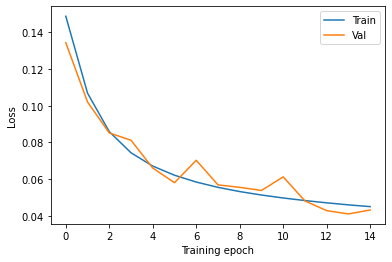

In [9]:
# number of epochs to train the model
n_epochs = 15# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

# lists to be plotted at the end of the training

train_losses, val_losses = [], []

for epoch in range(n_epochs):

    # monitor losses
    train_loss = 0
    valid_loss = 0

        
    ###################
    # train the model #
    ###################
    model.train() # prep model for training

    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

        
    ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler) 
    valid_loss = valid_loss / len(valid_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss) 

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

# plot of the losses
plt.plot([*range(len(train_losses))], train_losses / np.sum(train_losses), label = "Train")
plt.plot([*range(len(train_losses))], val_losses / np.sum(val_losses), label = "Val")
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Evaluation

Maintenant que le modèle est entrainé, on l'évalue sur le test set et on affiche quelques exemples de prédictions.

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)

print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        #print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print("""
Overall accuracy {:0.2f} %
""".format(np.sum(class_correct) / np.sum(class_total) * 100))

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

On peut voir que le modèle atteint de bonnes performances (90% environ). Maintenant, on va définir un CNN et l'entrainer lui aussi sur MNIST.

### Définition d'un réseau convolutif

L'exemple ci-dessus a permis d'avoir un premier exemple du fonctionnement de Pytorch. Dans la suite, vous allez utiliser ce modèle pour implémenter vous-même un LeNet5. Jusqu'à présent, nous avons vu un type de couche : la couche complètement connectée ou <i> fully connected </i>. Ces couches sont notées $Fx$, où $x$ correspond à l'indice de la couche. 
Avec les réseaux convolutifs, on peut introduire deux nouveaux types de couches : 
* Les couches convolutives (notées $Cx$)
* Les couches de pooling ou de subsampling (notées $Sx$)

Ces couches sont définies dans le livre [DeepMaths](https://exo7math.github.io/deepmath-exo7/livre-deepmath.pdf) (p. 236 et suivantes pour les couches convolutives, p. 207 pour le subsampling).


#### Les couches convolutives

Pour implémenter une couche convolutive avec Pytorch, on utilise la fonction `Conv2D` du module `nn`. Les arguments de cette couche sont le nombre de canaux en entrée, `in_channels`, le nombre de canaux en sortie `out_channels`, la taille du noyaux `kernel_size` et la taille du stride, `stride`. Le `stride` est le pas (en pixels) appliqué au noyau. Pour un stride de 1, alors le noyau se déplace d'un pixel vers la droite, puis une fois la ligne terminée d'un pixel vers le bas. Un dernier paramètre est le `padding` qui correspond à un "agrandissement" artificiel de l'image lorsque le noyau passe sur les pixels au bord de l'image. 

On parle parfois de <i> feature map </i> pour désigner un ensemble d'unités de la couche convolutive pour lesquelles les poids sont identiques. Les features maps correspondent aux sorties de la couche convolutive. Dans l'exemple p.236 de DeepMaths, les features maps sont les filtres $M_1,\dots M_32$. 

#### Les couches de subsampling

Les couches de subsampling ou de pooling permettent de réduire la dimension des entrées. Le principe est de définir un noyau sur lequel on applique une opération de pooling (généralement moyenne ou max).

#### Les couches d'aplatissement

Ces couches consistent à reformater la sortie d'une couche convolutive (par exemple un tenseur $10\times10\times6$) en un vecteur de dimension 600. On utilise la fonction `nn.Flatten` pour faire cet aplatissement. 

#### L'architecture à implémenter

Vous pouvez retrouver cette architecture sur la figure 2 du papier accessible [au lien suivant](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). Dans notre implémentation, on se propose de découper le modèle en deux parties: un <i> feature extractor </i> et un <i> classifier </i> classique. On définit donc deux méthodes, `self.feature_extractor` et `self.classifier`. Les paramètres pour le feature extractor sont les suivants:

* Une couche $C_1$ qui consiste en la définition de 6 features maps (argument `out_channels`). Le noyau a une taille de 5, le stride est de 1 et le padding de 2. La couche se termine par une nonlinéarité `tanh`
* Une couche $S_2$ est une couche de pooling (voir [ici](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) pour la fonction à utiliser). Le kernel est de 2 et le padding de 2.
* Une couche $C_3$ est une couche qui prend les 6 features maps de $S_2$ en entrée et renvoie 16 features maps. Le noyau a une taille de 5, le stride est de 1. Il n'y a pas de padding.  La couche se termine par une nonlinéarité `tanh`
* Une couche $S_4$ est à nouveau une couche de pooling.
* Une couche $C_5$ est une dernière couche qui renvoie 120 feature maps. Le noyeau de cette couche est de taille 5. La couche se termine par une nonlinéarité `tanh`

A la suite de ces couches convolutives, on applique un réseau à deux couches classique. La dimension d'entrée est 120 (contre 28*28 pour les données source). La dimension de la couche cachée est 84 et la dimension de sortie 10. 

<i> Remarque </i> 

Vous pourrez trouver certaines implémentations avec une taille d'input valant 32*32 au lieu de 28*28. Dans ce cas, il n'y a pas de padding appliqué. L'agrandissement de la taille de l'input permet d'avoir des features maps d'une taille 28*28 (ce que permet de manière équivalente le padding de 2).

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        # Première partie du modèle, qui correspond aux couches convolutionnelles.

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding = 2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Flatten(start_dim = 1, end_dim = -1), # on applique un applatissement à la dernière couche pour renvoyer un vecteur [batch_size, 120] au classifieur
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        return logits# , probs

In [ ]:
# initialize the model, the loss and the criterion

n_classes = 10
model = LeNet5(n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

print(model)

# number of epochs to train the model
n_epochs = 15# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

# lists to be plotted at the end of the training

train_losses, val_losses = [], []

for epoch in range(n_epochs):

    # monitor losses
    train_loss = 0
    valid_loss = 0

        
    ###################
    # train the model #
    ###################
    model.train() # prep model for training

    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler) 
    valid_loss = valid_loss / len(valid_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss) 

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

# plot of the losses
plt.plot([*range(len(train_losses))], train_losses / np.sum(train_losses), label = "Train")
plt.plot([*range(len(train_losses))], val_losses / np.sum(val_losses), label = "Val")
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)

print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        #print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print("""
Overall accuracy {:0.2f} %
""".format(np.sum(class_correct) / np.sum(class_total) * 100))

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Exploration 

Maintenant, c'est à vous d'explorer le modèle et ses propriétés ! Vous pouvez jouer sur un grand nombre d'hyperparamètres: taille des noyaux, nombre de features maps, stride, padding, etc. Vous pouvez également comparer à extracteur de feature équivalent à quel point le réseau convolutif s'en sort mieux (ou pas). On peut également compter le nombre de paramètres à apprendre par rapport à un réseau complètement connecté de profondeur équivalente.

Pour aller plus loin, vous pouvez également explorer la forme des features maps qui ont été apprises par le modèle et les comparer avec des filtres "usuels" en computer vision. Vous pouvez également comparer les représentations en extranyant les vecteurs issus de la première couche cachée du MLP avec ceux issus des couches convolutives du LeNet5. Pour pouvoir visualiser ces vecteurs, vous pouvez faire une ACP ou bien utiliser l'algorithme du [t-SNE](https://fr.wikipedia.org/wiki/Algorithme_t-SNE). N'hésitez pas à me solliciter si vous souhaitez avec plus d'informations sur comment faire pour aller 'explorer' les modèles. 